In [38]:
import pandas as pd
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import IL
from censusdis.counties.illinois import COOK

from pathlib import Path

import divintseg as dis
import geopandas as gpd

import contextily as cx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Setup

In [2]:
CENSUS_API_KEY = None
DATASET = "dec/pl"
GROUP = "P1"

# Census tracts consist of a 4 digit identifier within county, and then an optional 2 digit suffix
tracts_near_north = [
    '080100',
    '080201',
    '080202',
    '080300',
    '080400',
    '842200',
    '081000',
    '081100',
    '081201',
    '081202',
    '081300',
    '081401',
    '081402',
    '081403',
    '081500',
    '081600',
    '081700',
    '081800',
    '081900',
    '838300',
]

## Download the data for Near North

In [3]:
df_stacked = pd.DataFrame()
download_vars_2010 = [
    'P001003',
    'P001004',
    'P001005',
    'P001006',
    'P001007',
    'P001008',
    'P001009'
]

rename_dict_2010 = {
    'P001003': 'race_white',
    'P001004': 'race_black',
    'P001005': 'race_native_american',
    'P001006': 'race_asian',
    'P001007': 'race_hawaiian_pi',
    'P001008': 'race_other',
    'P001009': 'race_two_or_more'
}

download_vars_2020 = [
    'P1_003N',
    'P1_004N',
    'P1_005N',
    'P1_006N',
    'P1_007N',
    'P1_008N',
    'P1_009N'
]

rename_dict_2020 = {
    'P1_003N': 'race_white',
    'P1_004N': 'race_black',
    'P1_005N': 'race_native_american',
    'P1_006N': 'race_asian',
    'P1_007N': 'race_hawaiian_pi',
    'P1_008N': 'race_other',
    'P1_009N': 'race_two_or_more'
}

rename_dict = {
    2010: rename_dict_2010,
    2020: rename_dict_2020
}

download_vars = {
    2010: download_vars_2010,
    2020: download_vars_2020
}

for year in [2010, 2020]:
    vars_to_keep = download_vars[year]

    df_near_north = ced.download(
        dataset=DATASET,
        vintage=year,
        # leaves_of_group=GROUP,
        download_variables=download_vars[year],
        state=IL,
        county=COOK,
        tract=tracts_near_north,
        block='*',
        api_key=CENSUS_API_KEY,
    )

    df_near_north = df_near_north.rename(columns=rename_dict[year])

    # Collapse to the tract level
    race_cols = [col for col in df_near_north.columns if col.startswith('race_')]
    df_near_north_tract = df_near_north.pivot_table(
        index=['TRACT'],
        values=race_cols,
        aggfunc='sum'
    ).reset_index()

    # Calculate total pop and % race based on the race columns, not census columns
    df_near_north_tract['pop_total_race'] = df_near_north_tract.filter(like='race').sum(axis=1)
    df_near_north_tract[[f'{c}_pct' for c in race_cols]] = df_near_north_tract[
        race_cols
    ].div(df_near_north_tract['pop_total_race'], axis=0)

    df_near_north_final = dis.di(
        df_communities=df_near_north,
        by=['STATE', 'COUNTY', 'TRACT'], 
        over='BLOCK'
    ).reset_index().merge(
        df_near_north_tract,
        on='TRACT',
        how='left'
    )

    df_near_north_final['year'] = year
    df_stacked = pd.concat([df_stacked, df_near_north_final]) 

c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),
c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),


In [4]:
df_stacked = ced.add_inferred_geography(df_stacked, 2020)
df_stacked.head(10)

,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,race_two_or_more,race_white,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry
0,17,031,080100,0.176103,0.172607,275,150,0,4,47,89,5448,6013,0.906037,0.024946,0.000665,0.045734,0.000000,0.007816,0.014801,2010,"POLYGON ((-87.62889 41.91122, -87.62573 41.911..."
1,17,031,080201,0.196036,0.193356,144,109,0,2,39,52,2941,3287,0.894737,0.033161,0.000608,0.043809,0.000000,0.011865,0.015820,2010,"POLYGON ((-87.63323 41.91116, -87.63308 41.911..."
2,17,031,080202,0.203878,0.200772,215,79,0,4,29,59,3112,3498,0.889651,0.022584,0.001144,0.061464,0.000000,0.008290,0.016867,2010,"POLYGON ((-87.63312 41.9077, -87.63157 41.9078..."
3,17,031,080300,0.297783,0.278195,327,266,2,5,39,86,3590,4315,0.831981,0.061645,0.001159,0.075782,0.000463,0.009038,0.019930,2010,"POLYGON ((-87.63859 41.91112, -87.63762 41.911..."
4,17,031,080400,0.517231,0.225308,94,2568,1,4,29,76,1545,4317,0.357887,0.594858,0.000927,0.021774,0.000232,0.006718,0.017605,2010,"POLYGON ((-87.64343 41.91102, -87.64306 41.911..."
5,17,031,081000,0.411195,0.369717,684,925,2,11,105,147,5672,7546,0.751657,0.122582,0.001458,0.090644,0.000265,0.013915,0.019481,2010,"POLYGON ((-87.63448 41.90385, -87.633 41.90388..."
6,17,031,081100,0.419019,0.344908,337,466,4,6,49,65,2713,3640,0.745330,0.128022,0.001648,0.092582,0.001099,0.013462,0.017857,2010,"POLYGON ((-87.62999 41.90392, -87.62868 41.903..."
7,17,031,081201,0.280625,0.273287,318,175,1,2,59,82,3422,4059,0.843065,0.043114,0.000493,0.078344,0.000246,0.014536,0.020202,2010,"POLYGON ((-87.62834 41.90156, -87.6272 41.9015..."
8,17,031,081202,0.176519,0.172100,135,74,0,4,25,44,2713,2995,0.905843,0.024708,0.001336,0.045075,0.000000,0.008347,0.014691,2010,"POLYGON ((-87.62868 41.90394, -87.62798 41.903..."
9,17,031,081300,0.280341,0.272919,485,179,0,2,30,78,4110,4884,0.841523,0.036650,0.000410,0.099304,0.000000,0.006143,0.015971,2010,"POLYGON ((-87.6241 41.89839, -87.62413 41.8992..."


## Wrangle 2000 separately

In [5]:
df_near_north_2000 = pd.read_csv(Path(Path.cwd() / 'data' / 'census_2000.csv'))

# 2000 census tracts: https://www.chicago.gov/content/dam/city/depts/zlup/Zoning_Main_Page/Publications/Census_2000_Community_Area_Profiles/PDF_08.pdf
tracts_near_north_2000 = [t for t in range(80100, 82000, 100)] + [80201]

df_near_north_2000 = df_near_north_2000.query(
    'TRACTA in @tracts_near_north_2000'
)

df_near_north_2000 = df_near_north_2000[
    [
        'STATEA',
        'COUNTYA',
        'TRACTA',
        'BLOCKA',
        'FYE001',
        'FYE002',
        'FYE003',
        'FYE004',
        'FYE005',
        'FYE006',
        'FYE007',
        'GISJOIN'
    ]
]

<positron-console-cell-5>:1: DtypeWarning: Columns (13,28,29,30,33,44) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
df_near_north_2000.head(10)

,STATEA,COUNTYA,TRACTA,BLOCKA,FYE001,FYE002,FYE003,FYE004,FYE005,FYE006,FYE007,GISJOIN
36551,17,31.0,80100,1000,0,0,0,0,0,0,0,G17003100801001000
36552,17,31.0,80100,1001,0,0,0,0,0,0,0,G17003100801001001
36553,17,31.0,80100,1002,726,9,0,12,0,16,6,G17003100801001002
36554,17,31.0,80100,1003,152,0,0,0,0,0,0,G17003100801001003
36555,17,31.0,80100,1004,497,12,3,14,0,14,3,G17003100801001004
36556,17,31.0,80100,1005,1011,35,1,47,1,9,5,G17003100801001005
36557,17,31.0,80100,1006,0,0,0,0,0,0,0,G17003100801001006
36558,17,31.0,80100,1007,0,0,0,0,0,0,0,G17003100801001007
36559,17,31.0,80100,1008,0,0,0,0,0,0,0,G17003100801001008
36560,17,31.0,80100,1009,0,0,0,0,0,0,0,G17003100801001009


In [7]:
# Wrangle to stack with the other data
rename_dict_2000 = {
    'STATEA': 'STATE',
    'COUNTYA': 'COUNTY',
    'TRACTA': 'TRACT',
    'BLOCKA': 'BLOCK',
    'FYE001': 'race_white',
    'FYE002': 'race_black',
    'FYE003': 'race_native_american',
    'FYE004': 'race_asian',
    'FYE005': 'race_hawaiian_pi',
    'FYE006': 'race_other',
    'FYE007': 'race_two_or_more'
}

df_near_north_2000 = df_near_north_2000.rename(columns=rename_dict_2000)

df_near_north_2000['COUNTY'] = df_near_north_2000['COUNTY'].astype(int)

df_near_north_2000['STATE'] = df_near_north_2000['STATE'].apply(lambda x: f"{x:02}")
df_near_north_2000['COUNTY'] = df_near_north_2000['COUNTY'].apply(lambda x: f"{x:03}")
df_near_north_2000['TRACT'] = df_near_north_2000['TRACT'].apply(lambda x: f"{x:06}")

# Trim GISJOIN column of the final 4 numbers, which is block
df_near_north_2000['GISJOIN'] = df_near_north_2000['GISJOIN'].str[:-4]

# Collapse to the tract level
df_near_north_2000_tract = df_near_north_2000.pivot_table(
    index=['TRACT'],
    values=race_cols,
    aggfunc='sum'
).reset_index()

# Calculate total pop and % race based on the race columns, not census columns
df_near_north_2000_tract['pop_total_race'] = df_near_north_2000_tract.filter(like='race').sum(axis=1)
df_near_north_2000_tract[[f'{c}_pct' for c in race_cols]] = df_near_north_2000_tract[
    race_cols
].div(df_near_north_2000_tract['pop_total_race'], axis=0)

df_near_north_2000_final = dis.di(
    df_communities=df_near_north_2000,
    by=['STATE', 'COUNTY', 'TRACT'], 
    over='BLOCK'
).reset_index().merge(
    df_near_north_2000[['TRACT', 'GISJOIN']],
    on=['TRACT'],
    how='left'
).drop_duplicates(
    subset='TRACT',
    keep='first'
).merge(
    df_near_north_2000_tract,
    on='TRACT',
    how='left'
).reset_index()

df_near_north_2000_final['year'] = 2000

c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),


In [8]:
df_near_north_2000_final.head(10)

,index,STATE,COUNTY,TRACT,diversity,integration,GISJOIN,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,race_two_or_more,race_white,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year
0,0,17,031,080100,0.135256,0.133233,G1700310080100,201,164,1,8,59,56,6406,6895,0.929079,0.023785,0.001160,0.029152,0.000145,0.008557,0.008122,2000
1,1,17,031,080200,0.207206,0.205483,G1700310080200,338,304,2,6,46,111,6398,7205,0.887994,0.042193,0.000833,0.046912,0.000278,0.006384,0.015406,2000
2,2,17,031,080300,0.334618,0.310560,G1700310080300,187,428,1,5,84,85,3307,4097,0.807176,0.104467,0.001220,0.045643,0.000244,0.020503,0.020747,2000
3,3,17,031,080400,0.402846,0.219108,G1700310080400,62,3332,2,4,48,77,967,4492,0.215272,0.741763,0.000890,0.013802,0.000445,0.010686,0.017142,2000
4,4,17,031,080500,0.087736,0.063902,G1700310080500,7,2454,0,3,8,11,88,2571,0.034228,0.954492,0.001167,0.002723,0.000000,0.003112,0.004278,2000
5,5,17,031,080600,0.593747,0.396607,G1700310080600,3,59,0,0,17,5,99,183,0.540984,0.322404,0.000000,0.016393,0.000000,0.092896,0.027322,2000
6,6,17,031,080700,0.549346,0.147783,G1700310080700,0,11,0,0,1,1,16,29,0.551724,0.379310,0.000000,0.000000,0.000000,0.034483,0.034483,2000
7,7,17,031,080800,0.035592,0.035000,G1700310080800,0,1688,0,2,4,5,20,1719,0.011635,0.981966,0.001163,0.000000,0.000000,0.002327,0.002909,2000
8,8,17,031,080900,0.602725,0.591100,G1700310080900,45,300,6,0,9,28,358,746,0.479893,0.402145,0.000000,0.060322,0.008043,0.012064,0.037534,2000
9,9,17,031,081000,0.404648,0.360712,G1700310081000,499,991,11,12,89,186,5542,7330,0.756071,0.135198,0.001637,0.068076,0.001501,0.012142,0.025375,2000


In [9]:
# Add census shapefiles
census_2000_shp = gpd.read_file('zip://data/census_2000/shapefiles.zip/US_tract_2000.shp')
census_2000_shp = census_2000_shp[['GISJOIN', 'geometry']]
census_2000_shp.head(10)

census_2000_shp = census_2000_shp.to_crs('EPSG:4269')

In [10]:
df_near_north_2000_final = df_near_north_2000_final.merge(
    census_2000_shp,
    on=['GISJOIN'],
    how='left'
)

df_near_north_2000_final.head(10)
df_near_north_2000_final = df_near_north_2000_final.drop(columns=['GISJOIN'])

In [11]:
df_near_north_2000_final.head(10)

,index,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,race_two_or_more,race_white,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry
0,0,17,031,080100,0.135256,0.133233,201,164,1,8,59,56,6406,6895,0.929079,0.023785,0.001160,0.029152,0.000145,0.008557,0.008122,2000,"POLYGON ((-87.62405 41.90423, -87.62476 41.904..."
1,1,17,031,080200,0.207206,0.205483,338,304,2,6,46,111,6398,7205,0.887994,0.042193,0.000833,0.046912,0.000278,0.006384,0.015406,2000,"POLYGON ((-87.62865 41.90403, -87.63005 41.904..."
2,2,17,031,080300,0.334618,0.310560,187,428,1,5,84,85,3307,4097,0.807176,0.104467,0.001220,0.045643,0.000244,0.020503,0.020747,2000,"POLYGON ((-87.63305 41.90393, -87.63458 41.903..."
3,3,17,031,080400,0.402846,0.219108,62,3332,2,4,48,77,967,4492,0.215272,0.741763,0.000890,0.013802,0.000445,0.010686,0.017142,2000,"POLYGON ((-87.63855 41.90383, -87.63925 41.903..."
4,4,17,031,080500,0.087736,0.063902,7,2454,0,3,8,11,88,2571,0.034228,0.954492,0.001167,0.002723,0.000000,0.003112,0.004278,2000,"POLYGON ((-87.64335 41.91073, -87.64335 41.910..."
5,5,17,031,080600,0.593747,0.396607,3,59,0,0,17,5,99,183,0.540984,0.322404,0.000000,0.016393,0.000000,0.092896,0.027322,2000,"POLYGON ((-87.64845 41.90853, -87.64845 41.907..."
6,6,17,031,080700,0.549346,0.147783,0,11,0,0,1,1,16,29,0.551724,0.379310,0.000000,0.000000,0.000000,0.034483,0.034483,2000,"POLYGON ((-87.64315 41.90053, -87.64315 41.899..."
7,7,17,031,080800,0.035592,0.035000,0,1688,0,2,4,5,20,1719,0.011635,0.981966,0.001163,0.000000,0.000000,0.002327,0.002909,2000,"POLYGON ((-87.63745 41.89893, -87.63795 41.898..."
8,8,17,031,080900,0.602725,0.591100,45,300,6,0,9,28,358,746,0.479893,0.402145,0.000000,0.060322,0.008043,0.012064,0.037534,2000,"POLYGON ((-87.63445 41.90053, -87.63442 41.899..."
9,9,17,031,081000,0.404648,0.360712,499,991,11,12,89,186,5542,7330,0.756071,0.135198,0.001637,0.068076,0.001501,0.012142,0.025375,2000,"POLYGON ((-87.62995 41.89663, -87.63135 41.896..."


In [12]:
df_near_north_2000_final_crs = gpd.GeoDataFrame(
    df_near_north_2000_final, 
    geometry='geometry'
)

df_stacked = pd.concat([df_stacked, df_near_north_2000_final_crs]).sort_values(by='year')
df_stacked.head(10)

,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,race_two_or_more,race_white,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry,index
8,17,031,080900,0.602725,0.591100,45,300,6,0,9,28,358,746,0.479893,0.402145,0.000000,0.060322,0.008043,0.012064,0.037534,2000,"POLYGON ((-87.63445 41.90053, -87.63442 41.899...",8.0
9,17,031,081000,0.404648,0.360712,499,991,11,12,89,186,5542,7330,0.756071,0.135198,0.001637,0.068076,0.001501,0.012142,0.025375,2000,"POLYGON ((-87.62995 41.89663, -87.63135 41.896...",9.0
10,17,031,081100,0.373200,0.333548,229,481,6,5,42,61,2894,3718,0.778375,0.129371,0.001345,0.061592,0.001614,0.011296,0.016407,2000,"POLYGON ((-87.6283 41.89663, -87.62995 41.8966...",10.0
11,17,031,081200,0.193304,0.183942,314,231,2,12,63,113,6352,7087,0.896289,0.032595,0.001693,0.044306,0.000282,0.008890,0.015945,2000,"POLYGON ((-87.62405 41.90423, -87.62344 41.903...",11.0
12,17,031,081300,0.275336,0.250047,581,171,7,3,41,103,4928,5834,0.844703,0.029311,0.000514,0.099589,0.001200,0.007028,0.017655,2000,"POLYGON ((-87.61875 41.90013, -87.61835 41.900...",12.0
13,17,031,081400,0.386537,0.376450,1270,665,2,6,99,177,7368,9587,0.768541,0.069365,0.000626,0.132471,0.000209,0.010326,0.018463,2000,"POLYGON ((-87.60255 41.89633, -87.60246 41.893...",13.0
14,17,031,081500,0.321367,0.309486,257,231,0,7,41,53,2620,3209,0.816454,0.071985,0.002181,0.080087,0.000000,0.012777,0.016516,2000,"POLYGON ((-87.62425 41.89263, -87.62415 41.891...",14.0
15,17,031,081600,0.354853,0.348596,174,171,1,6,28,33,1588,2001,0.793603,0.085457,0.002999,0.086957,0.000500,0.013993,0.016492,2000,"POLYGON ((-87.62815 41.88773, -87.62955 41.887...",15.0
0,17,031,080100,0.135256,0.133233,201,164,1,8,59,56,6406,6895,0.929079,0.023785,0.001160,0.029152,0.000145,0.008557,0.008122,2000,"POLYGON ((-87.62405 41.90423, -87.62476 41.904...",0.0
1,17,031,080200,0.207206,0.205483,338,304,2,6,46,111,6398,7205,0.887994,0.042193,0.000833,0.046912,0.000278,0.006384,0.015406,2000,"POLYGON ((-87.62865 41.90403, -87.63005 41.904...",1.0


## Compute diversity and integration

TODO: add explanation of diversity/integration from `divintseg`

## Plot

## Diversity

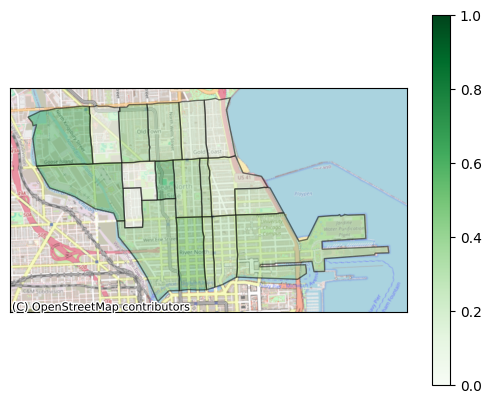

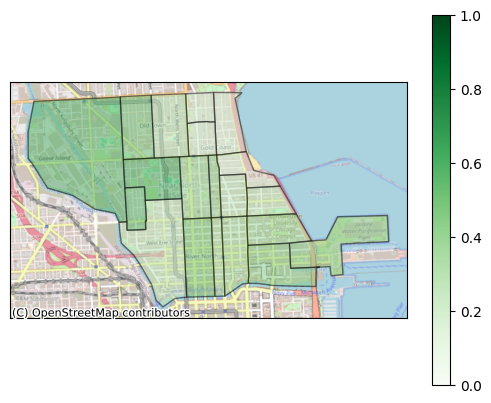

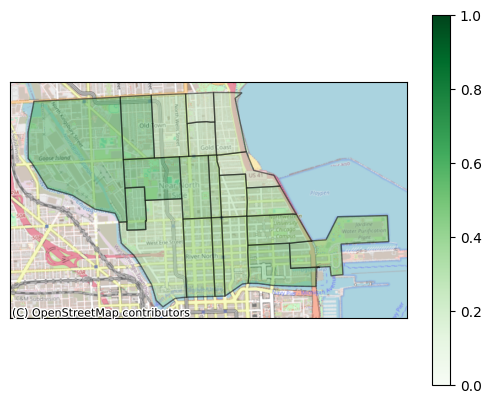

In [13]:
for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    ax = cem.plot_map(
        df_to_plot,
        "diversity",
        cmap="Greens",
        edgecolor="black",
        alpha=0.5,
        with_background=True,
        legend=True,
        vmin=0.0,
        vmax=1.0,
    )

## Integration

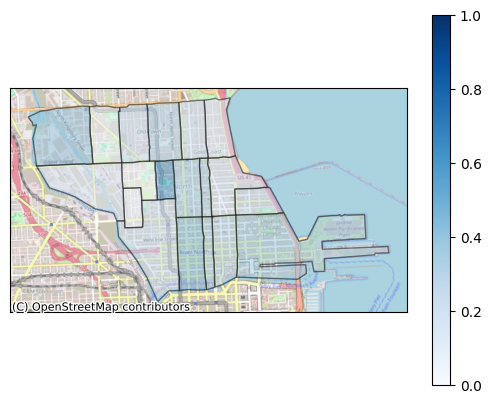

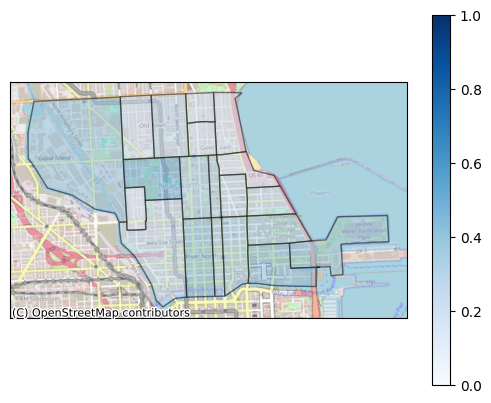

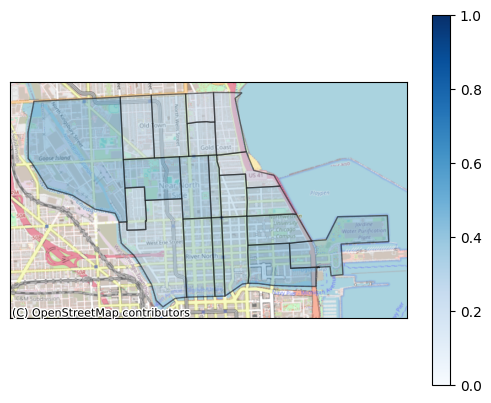

In [14]:
for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    ax = cem.plot_map(
        df_to_plot,
        "integration",
        cmap="Blues",
        edgecolor="black",
        alpha=0.5,
        with_background=True,
        legend=True,
        vmin=0.0,
        vmax=1.0,
    )

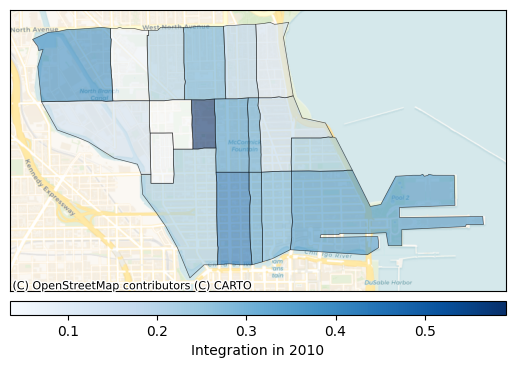

In [42]:
df_stacked_2000 = df_stacked[df_stacked['year'] == 2000]
df_stacked_2000 = df_stacked_2000.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

plot_2000 = df_stacked_2000.plot(
    column='integration',
    ax=ax,
    edgecolor='black',
    alpha=0.6,
    linewidth=0.5,
    cmap='Blues',
    legend=True,
    cax=cax,
    legend_kwds={"label": "Integration in 2010", "orientation": "horizontal"},
)

# Remove tick labels and ticks
plot_2000.set_xticks([])
plot_2000.set_yticks([])
plot_2000.set_xticklabels([])
plot_2000.set_yticklabels([])

# Keep the frame (border)
for spine in plot_2000.spines.values():
    spine.set_visible(True)
cx.add_basemap(plot_2000, source=cx.providers.CartoDB.Voyager)

## Percent Black

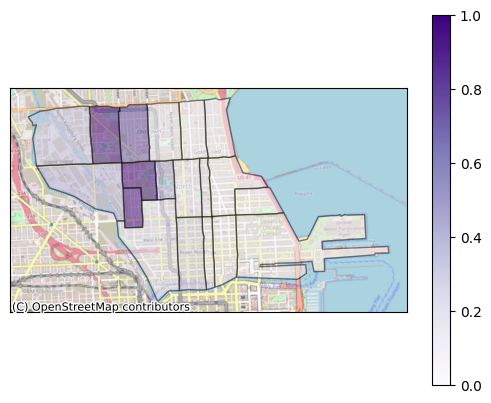

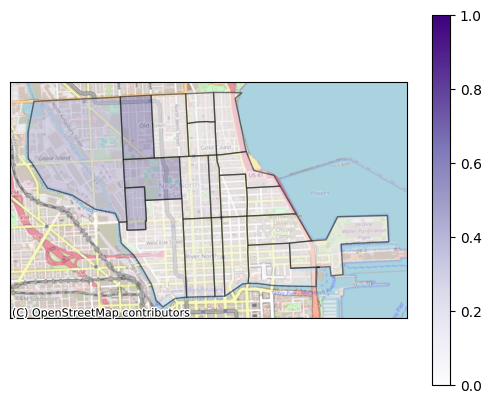

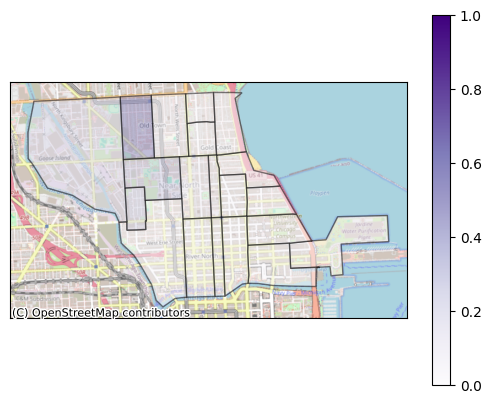

In [ ]:
for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    ax = cem.plot_map(
        df_to_plot,
        "race_black_pct",
        cmap="Purples",
        edgecolor="black",
        alpha=0.5,
        with_background=True,
        legend=True,
        vmin=0.0,
        vmax=1.0,
    )

In [90]:
df_stacked.query('TRACT == "838300"').head(10)

,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,...,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry,index
18,17,031,838300,0.622225,0.507960,157,861,3,8,84,...,0.294298,0.527897,0.004905,0.096260,0.001839,0.051502,0.023299,2010,"POLYGON ((-87.64322 41.90372, -87.63955 41.903...",NaN
38,17,031,838300,0.614375,0.508314,217,786,0,10,59,...,0.531395,0.304651,0.003876,0.084109,0.000000,0.022868,0.053101,2020,"POLYGON ((-87.64322 41.90372, -87.63955 41.903...",NaN
